DATA CLEANING

In [2]:
import pandas as pd
import numpy as np
df = pd.read_csv("Telco-Customer-Churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
# Fix TotalCharges column
df['TotalCharges']=pd.to_numeric(df['TotalCharges'],errors='coerce')
df.isnull().sum()
# ok so 11 missing values in TotalCharges so we wil fill them with median
df['TotalCharges']=df['TotalCharges'].fillna(df['TotalCharges'].median())
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [4]:
# convert churn in binary 
df['Churn']=df['Churn'].map({'Yes':1,'No':0})
df['Churn'].value_counts()

Churn
0    5174
1    1869
Name: count, dtype: int64

In [5]:
# as customer id is unique, no predictive power and can cause of so we will drop it
df=df.drop('customerID',axis=1)
# we can add inplace=True to make the changes in the same dataframe

In [6]:
df.isnull().sum()
df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2281.916928,0.265370
std,0.368612,24.559481,30.090047,2265.270398,0.441561
min,0.000000,0.000000,18.250000,18.800000,0.000000
25%,0.000000,9.000000,35.500000,402.225000,0.000000
50%,0.000000,29.000000,70.350000,1397.475000,0.000000
75%,0.000000,55.000000,89.850000,3786.600000,1.000000
max,1.000000,72.000000,118.750000,8684.800000,1.000000


FE and ENCODING

In [7]:
X = df.drop('Churn', axis=1)
y = df['Churn']

num_features=[
    'tenure',
    'MonthlyCharges',
    'TotalCharges'
]
# from this will identify num features 
X[num_features].describe()


,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000
mean,32.371149,64.761692,2281.916928
std,24.559481,30.090047,2265.270398
min,0.000000,18.250000,18.800000
25%,9.000000,35.500000,402.225000
50%,29.000000,70.350000,1397.475000
75%,55.000000,89.850000,3786.600000
max,72.000000,118.750000,8684.800000


In [8]:
# ok lets separete cat and num vals
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

print("Categorical columns:", categorical_cols)
print("Numerical columns:", numerical_cols) 

# we have 19 categorical columns and 4 numerical columns

Categorical columns: Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod'],
      dtype='object')
Numerical columns: Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')


In [9]:
# preform 1-hot encoding on categorical columns
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)
X_encoded.shape
feature_cols = X_encoded.columns

REMEMBER: The difference in the number of encoded features compared to earlier experiments is due to consistent re-engineering of
the pipeline, including target separation and one-hot encoding with `drop_first=True`, which may result in one fewer dummy
variable without affecting model performance.


TRAIN-TEST SPLIT

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train,y_test=train_test_split(X_encoded,y,test_size=0.2,random_state=42,stratify=y)

In [38]:
# SCALLING 
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[num_features] = scaler.fit_transform(X_train[num_features])
X_test_scaled[num_features] = scaler.transform(X_test[num_features])


MODELING= LOGISTIC REGRESSION WITH BALANCED CLASS WEIGHT


In [39]:
# Logr provides interpretability and stable performance for churn prediction when recall is prioritized.

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score

log_reg = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
log_reg.fit(X_train_scaled, y_train)

y_proba = log_reg.predict_proba(X_test_scaled)[:, 1]

# Default threshold (we will tune later)
y_pred = (y_proba >= 0.5).astype(int)


In [40]:
# lets evaluate the model

print("Accuracy:", accuracy_score(y_test,y_pred))
print("ROC AUC Score:", roc_auc_score(y_test,y_proba))  
print("Classification Report:\n", classification_report(y_test,y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test,y_pred))
print("Recall:", recall_score(y_test,y_pred))
print("Precision:", precision_score(y_test,y_pred))

Accuracy: 0.7388218594748048
ROC AUC Score: 0.8417189800821514
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.72      0.80      1035
           1       0.51      0.78      0.61       374

    accuracy                           0.74      1409
   macro avg       0.70      0.75      0.71      1409
weighted avg       0.80      0.74      0.75      1409

Confusion Matrix:
 [[748 287]
 [ 81 293]]
Recall: 0.7834224598930482
Precision: 0.5051724137931034


In [41]:
'''note:
FN=81-> controlled and acceptable for churn
Recall>Accuracy-> correct priority
ROC-AUC stable-> model has good separability'''

'note:\nFN=81-> controlled and acceptable for churn\nRecall>Accuracy-> correct priority\nROC-AUC stable-> model has good separability'

Feature Importance

In [42]:
# In balanced logR, feature importANCE= coeff not .feature_importance_
# lets extract coeff
import pandas as pd

feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': log_reg.coef_[0]
})


In [43]:
# add absolute coefficient for better interpretability
feature_importance['Abs_Coefficient'] = feature_importance['Coefficient'].abs()

# will get top 10 features
top_features = feature_importance.sort_values(
    by='Abs_Coefficient', ascending=False
).head(10)
top_features


'''
Positive coefficient: increases churn probability
Negative coefficient: reduces churn probability
'''


'\nPositive coefficient: increases churn probability\nNegative coefficient: reduces churn probability\n'

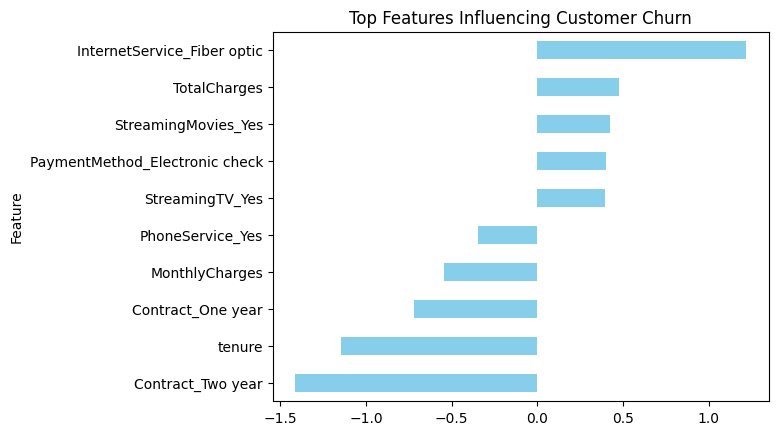

In [44]:
#lets visualize
import matplotlib.pyplot as plt

top_features.sort_values('Coefficient').plot(
    x='Feature',
    y='Coefficient',
    kind='barh',
    legend=False,
    color='skyblue',
)
plt.title("Top Features Influencing Customer Churn")
plt.show()




In [46]:
import joblib
joblib.dump(log_reg, 'logistic_regression_churn_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(feature_cols, 'feature_columns.pkl')

['feature_columns.pkl']